# Оптимизация GE

## Характеристики оборудования:

Операционная система:

In [13]:
!cat /etc/os-release

PRETTY_NAME="Ubuntu 21.10"
NAME="Ubuntu"
VERSION_ID="21.10"
VERSION="21.10 (Impish Indri)"
VERSION_CODENAME=impish
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=impish


CPU:

In [17]:
!lscpu | grep 'Model name'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep 'MHz'
!lscpu | grep 'cache'

Model name:                      11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz
Socket(s):                       1
Core(s) per socket:              4
Thread(s) per core:              2
CPU MHz:                         3100.000
CPU max MHz:                     4400,0000
CPU min MHz:                     400,0000
L1d cache:                       192 KiB
L1i cache:                       128 KiB
L2 cache:                        5 MiB
L3 cache:                        8 MiB


RAM:

In [15]:
!grep MemTotal /proc/meminfo

MemTotal:       16176172 kB


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.options.display.float_format = '{:.7f}'.format
sns.set(font_scale = 1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

## Анализ количества flops

$\texttt{composeG}:$ 
- mul: $678$
- add: $563$

$\texttt{composeG_raw}:$ 
- mul: $21 + n \times 64$
- add: $15 + n \times 48$

Можно также учитывать, что матрица $g g^T$ является симметрической. В этом случае:

$\texttt{composeG_raw}:$ 
- mul: $21 + n \times 58$
- add: $15 + n \times 42$

In [30]:
def ops_composeG_raw(x):
    return 36 + x * 112

def ops_composeG(x):
    return 0 * x + 1241

In [31]:
cor_num = np.arange(5, 12)

In [32]:
ops_data = {"ops_composeG_raw": ops_composeG_raw(cor_num), "ops_composeG": ops_composeG(cor_num)}

In [38]:
df = pd.DataFrame(data=ops_data, index=cor_num)

In [39]:
df

,ops_composeG_raw,ops_composeG
5,596,1241
6,708,1241
7,820,1241
8,932,1241
9,1044,1241
10,1156,1241
11,1268,1241


In [51]:
ops_composeG(8)

1241

In [50]:
ops_composeG_raw(8)

932

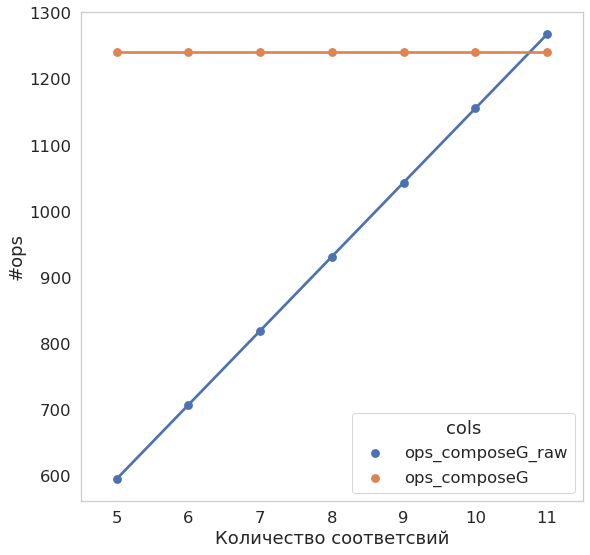

In [49]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.pointplot(
    ax=ax,
    x="index", 
    y="vals", 
    hue='cols', 
    data=df.reset_index().melt(
        'index', var_name='cols',  value_name='vals'), 
    kind='point')
ax.set(ylabel=f"#ops", xlabel="Количество соответсвий");

In [31]:
def plot_bars(y='time', unit='ms', capitalize=True):
    fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

    for i, (est_name, est) in enumerate(esimators.items()):
            order = stability_df.groupby(["method_name"])[y].aggregate(est).reset_index().sort_values(y)
            sns.barplot(
                ax=axes[i], 
                x="method_name", 
                y=y, 
                data=stability_df,
                estimator=est,
                order=order['method_name']
            )

            axes[i].set(ylabel=f"{y.capitalize() if capitalize else y}, {unit} ({est_name})", xlabel="Algorithm")
            axes[i].yaxis.label.set_size(25)
            axes[i].xaxis.label.set_size(25)
            axes[i].tick_params(axis='x', rotation=45)

In [25]:
esimators = {"median": np.median, "mean": np.mean}
stability_df['time'] = stability_df['time'] * 1000

In [37]:
stability_inf_mask = stability_df["ATE"].isin([np.inf, -np.inf])
stability_99q_mask = stability_df["ATE"] < stability_df["ATE"].quantile(.99)
stability_df[~stability_inf_mask & stability_99q_mask].groupby(
    ["method_name"])[["ARE", "ATE", "RTE", "time"]].describe().T

method_name      ge_10pt  ge_10pt_raw       ge_6pt   ge_6pt_raw       ge_7pt  \
ARE  count  9953.0000000 9953.0000000 9800.0000000 9800.0000000 9896.0000000   
     mean      0.0189005    0.0189004    0.0844422    0.0844418    0.0562022   
     std       0.0514111    0.0514124    0.0854427    0.0854440    0.0812217   
     min       0.0000003    0.0000004    0.0000011    0.0000009    0.0000013   
     25%       0.0011320    0.0011320    0.0218271    0.0218271    0.0040724   
     50%       0.0026932    0.0026916    0.0630557    0.0630544    0.0207601   
     75%       0.0071134    0.0071134    0.1137927    0.1137927    0.0769711   
     max       0.6676290    0.6676300    0.9377980    0.9377960    0.7193380   
ATE  count  9953.0000000 9953.0000000 9800.0000000 9800.0000000 9896.0000000   
     mean      1.5760062    1.5760595    6.3778220    6.3778378    4.0656942   
     std       6.1392943    6.1394460   11.0989672   11.0958167    8.7099402   
     min       0.0000046    0.0000041    0.0000289    0.0000292    0.0000158   
     25%       0.0316678    0.0315901    0.8056887    0.8056860    0.1451440   
     50%       0.0860284    0.0860281    3.0937050    3.0937300    0.9340550   
     75%       0.2924070    0.2924880    6.4345675    6.4342150    4.6749125   
     max      94.3908000   94.3910000   94.8332000   94.8092000   95.6505000   
RTE  count  9953.0000000 9953.0000000 9800.0000000 9800.0000000 9896.0000000   
     mean      0.1111729    0.1111718    0.5241545    0.5241399    0.3783106   
     std       0.3271366    0.3271378    0.5796642    0.5796508    0.5642815   
     min       0.0000002    0.0000003    0.0000023    0.0000020    0.0000008   
     25%       0.0029073    0.0029094    0.0693788    0.0692729    0.0125061   
     50%       0.0081449    0.0081397    0.2596450    0.2596455    0.0665215   
     75%       0.0246980    0.0248155    0.8261450    0.8261450    0.4622415   
     max       1.5708000    1.5708000    1.5708000    1.5708000    1.5708000   
time count  9953.0000000 9953.0000000 9800.0000000 9800.0000000 9896.0000000   
     mean      0.0000696    0.0000532    0.0000855    0.0000575    0.0000825   
     std       0.0000217    0.0000173    0.0000137    0.0000094    0.0000163   
     min       0.0000257    0.0000181    0.0000202    0.0000131    0.0000216   
     25%       0.0000488    0.0000365    0.0000884    0.0000591    0.0000871   
     50%       0.0000727    0.0000557    0.0000897    0.0000602    0.0000896   
     75%       0.0000910    0.0000702    0.0000911    0.0000615    0.0000910   
     max       0.0002214    0.0001765    0.0001046    0.0000795    0.0002572   

method_name   ge_7pt_raw       ge_8pt   ge_8pt_raw       ge_9pt   ge_9pt_raw  
ARE  count  9894.0000000 9915.0000000 9915.0000000 9937.0000000 9937.0000000  
     mean      0.0561879    0.0353546    0.0353541    0.0288182    0.0288172  
     std       0.0812235    0.0681121    0.0681132    0.0639643    0.0639629  
     min       0.0000009    0.0000002    0.0000002    0.0000002    0.0000003  
     25%       0.0040655    0.0017338    0.0017347    0.0013970    0.0013959  
     50%       0.0207411    0.0049577    0.0049487    0.0035849    0.0035867  
     75%       0.0769384    0.0381919    0.0381918    0.0183141    0.0183264  
     max       0.7193380    0.6702440    0.6702440    0.7655360    0.7655350  
ATE  count  9894.0000000 9915.0000000 9915.0000000 9937.0000000 9937.0000000  
     mean      4.0461988    2.6780308    2.6779046    2.2795661    2.2794063  
     std       8.6077159    7.7257070    7.7255901    7.1314717    7.1305352  
     min       0.0000100    0.0000041    0.0000030    0.0000040    0.0000023  
     25%       0.1452380    0.0501953    0.0501970    0.0391547    0.0390986  
     50%       0.9332495    0.1711990    0.1710440    0.1166400    0.1166870  
     75%       4.6730075    1.8135700    1.8135850    0.7927130    0.7927130  
     max      95.4938000   95.3958000   95.3949000   94.0043000   93.9986000  
RTE  count  9894

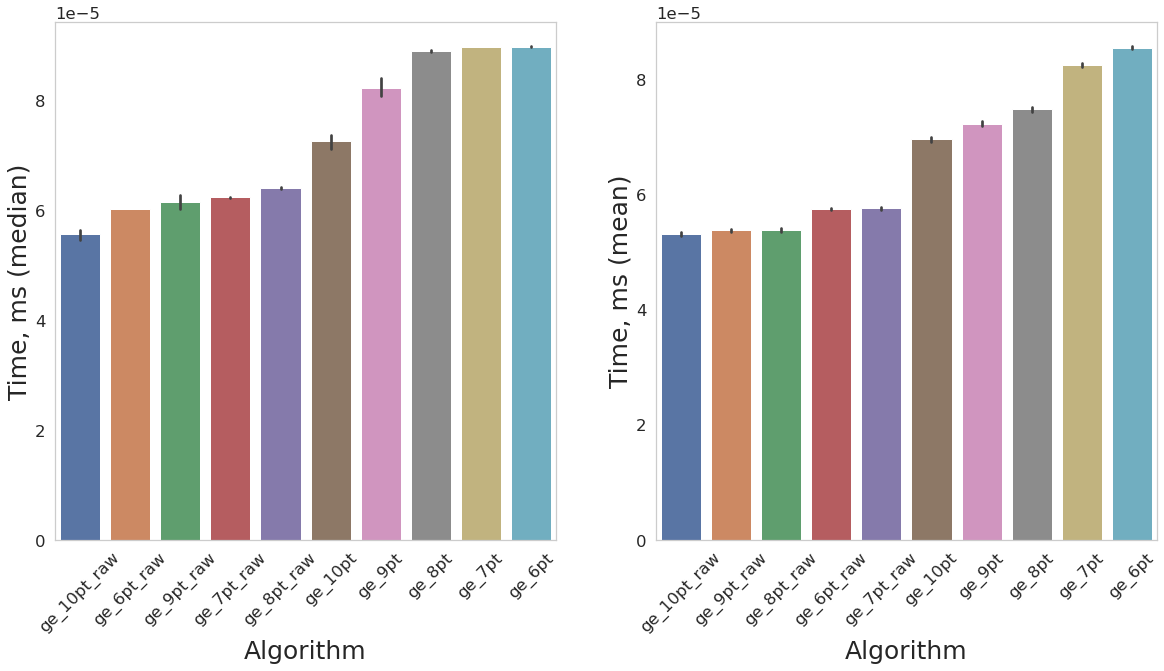

In [38]:
plot_bars()

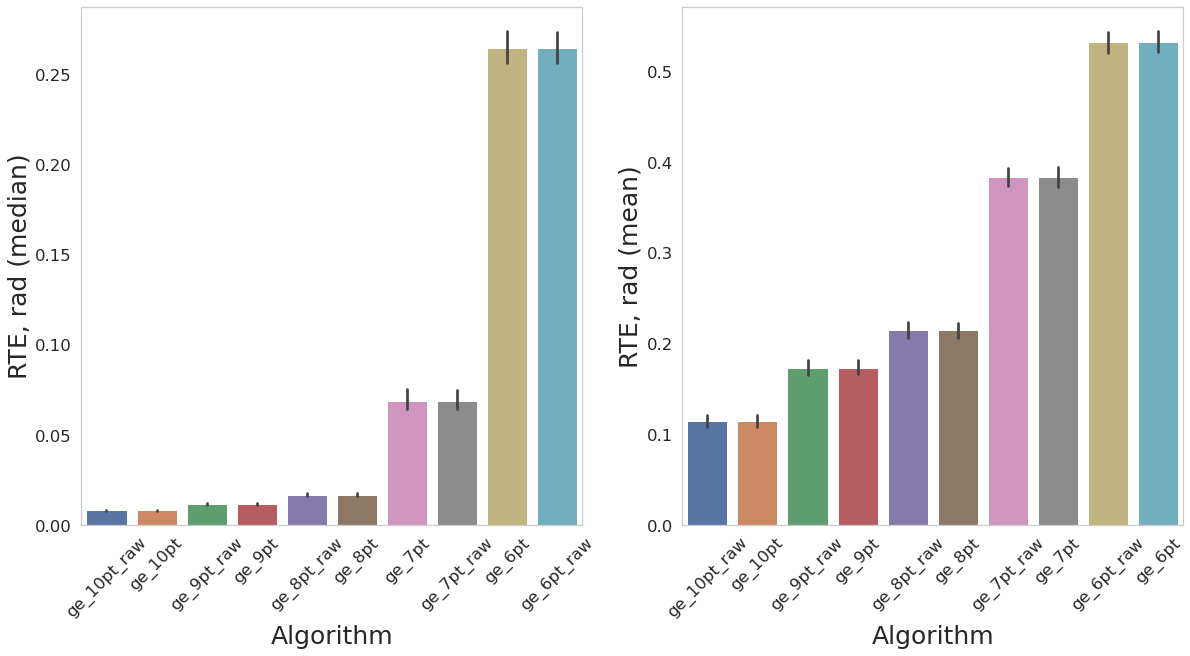

In [39]:
plot_bars('RTE', 'rad', capitalize=False)

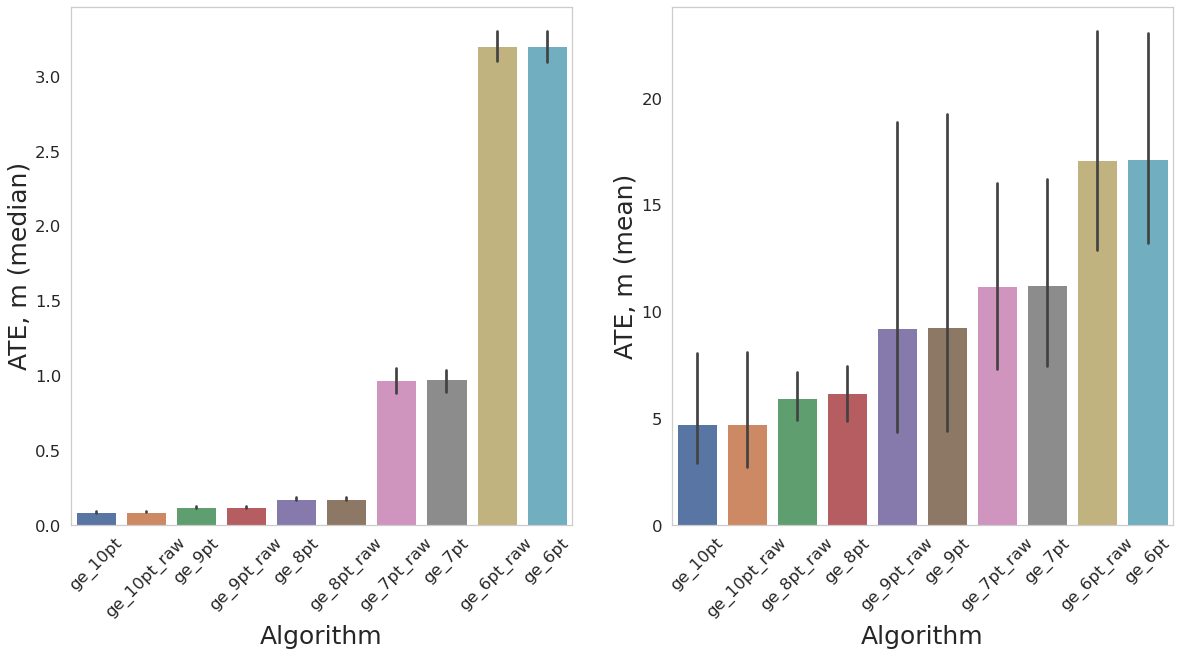

In [40]:
plot_bars('ATE', 'm', capitalize=False)

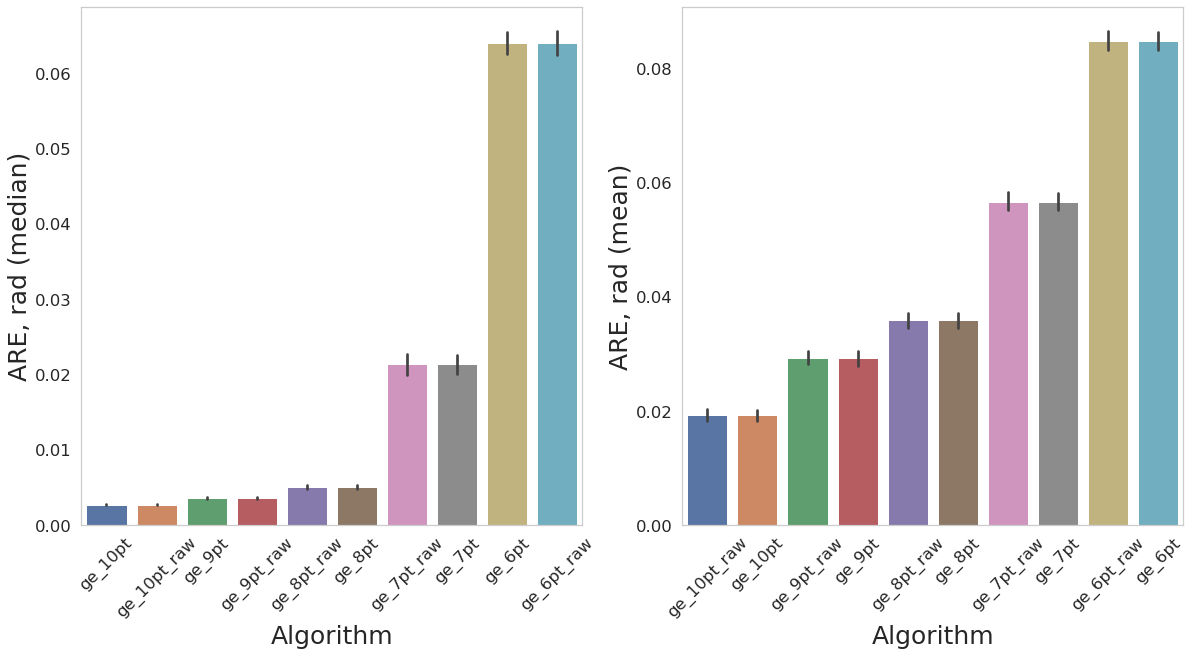

In [41]:
plot_bars('ARE', 'rad', capitalize=False)

## Сравнение реализаций GE

### Векторизованная версия

In [3]:
motion_df = pd.read_csv("./error_motion.csv")
stability_df = pd.read_csv("./error_stability.csv")

In [4]:
stability_inf_mask = stability_df["ATE"].isin([np.inf, -np.inf])
stability_99q_mask = stability_df["ATE"] < stability_df["ATE"].quantile(.99)
stability_df[~stability_inf_mask & stability_99q_mask].groupby(
    ["method_name"])[["ARE", "ATE", "RTE", "time"]].describe().T

method_name          8pt      8pt_raw
ARE  count  9893.0000000 9907.0000000
     mean      0.0352938    0.0357994
     std       0.0681595    0.0691228
     min       0.0000006    0.0000004
     25%       0.0017629    0.0017804
     50%       0.0048795    0.0051280
     75%       0.0371899    0.0376715
     max       0.6587250    0.7628190
ATE  count  9893.0000000 9907.0000000
     mean      2.6409428    2.6518421
     std       7.4620753    7.3871111
     min       0.0000079    0.0000040
     25%       0.0516239    0.0519543
     50%       0.1732640    0.1794560
     75%       1.7309000    1.8349750
     max      79.3104000   79.8292000
RTE  count  9893.0000000 9907.0000000
     mean      0.2058237    0.2057668
     std       0.4223610    0.4201445
     min       0.0000011    0.0000002
     25%       0.0049578    0.0051693
     50%       0.0164039    0.0171700
     75%       0.1230640    0.1287535
     max       1.5708000    1.5708000
time count  9893.0000000 9907.0000000
     mean      0.0000743    0.0000361
     std       0.0000206    0.0000099
     min       0.0000222    0.0000110
     25%       0.0000554    0.0000271
     50%       0.0000881    0.0000422
     75%       0.0000905    0.0000436
     max       0.0001162    0.0000491

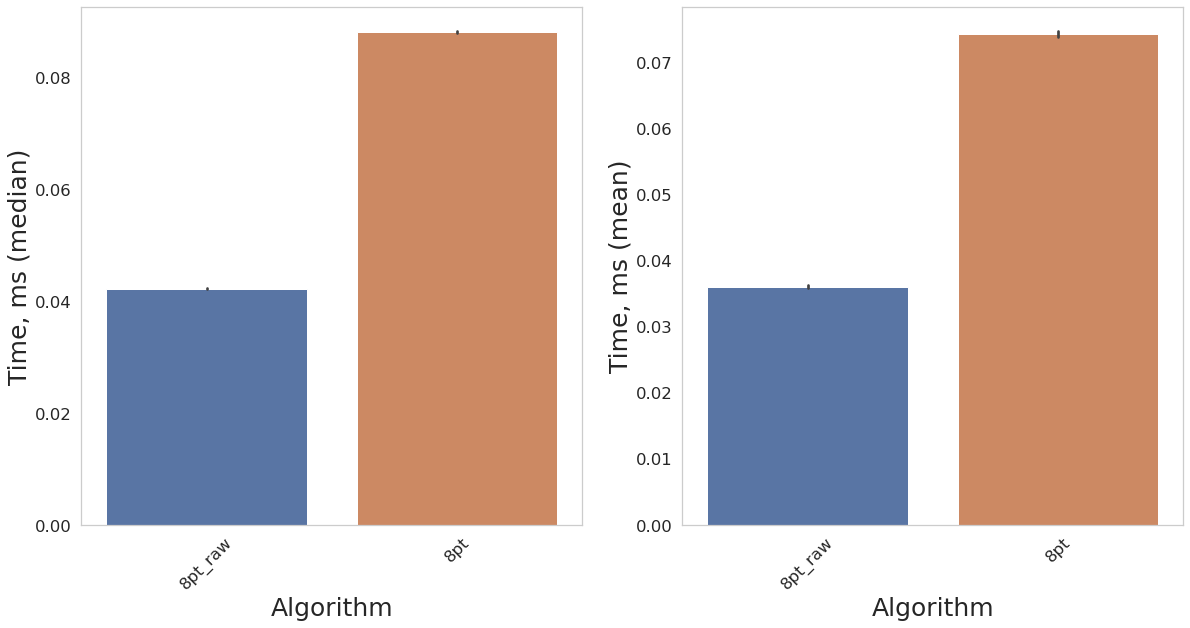

In [7]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

for i, (est_name, est) in enumerate(esimators.items()):
        order = stability_df.groupby(["method_name"])['time'].aggregate(est).reset_index().sort_values('time')
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="time", 
            data=stability_df,
            estimator=est,
            order=order['method_name']
        )
        
        axes[i].set(ylabel=f"Time, ms ({est_name})", xlabel="Algorithm")
        axes[i].yaxis.label.set_size(25)
        axes[i].xaxis.label.set_size(25)
        axes[i].tick_params(axis='x', rotation=45)

### Версия без векторизации

In [8]:
stability_inf_mask = stability_df["ATE"].isin([np.inf, -np.inf])
stability_99q_mask = stability_df["ATE"] < stability_df["ATE"].quantile(.99)
stability_df[~stability_inf_mask & stability_99q_mask].groupby(
    ["method_name"])[["ARE", "ATE", "RTE", "time"]].describe().T

method_name          8pt      8pt_raw
ARE  count  9907.0000000 9893.0000000
     mean      0.0357992    0.0352928
     std       0.0691237    0.0681601
     min       0.0000005    0.0000002
     25%       0.0017795    0.0017616
     50%       0.0051326    0.0048795
     75%       0.0376715    0.0371902
     max       0.7628200    0.6587240
ATE  count  9907.0000000 9893.0000000
     mean      2.6518316    2.6407873
     std       7.3868716    7.4621543
     min       0.0000081    0.0000054
     25%       0.0519622    0.0516315
     50%       0.1794280    0.1730430
     75%       1.8349000    1.7309900
     max      79.8289000   79.3099000
RTE  count  9907.0000000 9893.0000000
     mean      0.2057665    0.2058212
     std       0.4201448    0.4223636
     min       0.0000007    0.0000004
     25%       0.0051668    0.0049609
     50%       0.0171808    0.0164039
     75%       0.1287535    0.1230640
     max       1.5708000    1.5708000
time count  9907.0000000 9893.0000000
     mean      0.0000757    0.0000541
     std       0.0000210    0.0000154
     min       0.0000228    0.0000149
     25%       0.0000570    0.0000398
     50%       0.0000892    0.0000642
     75%       0.0000915    0.0000660
     max       0.0001460    0.0001051

In [6]:
esimators = {"median": np.median, "mean": np.mean}

In [5]:
stability_df['time'] = stability_df['time'] * 1000

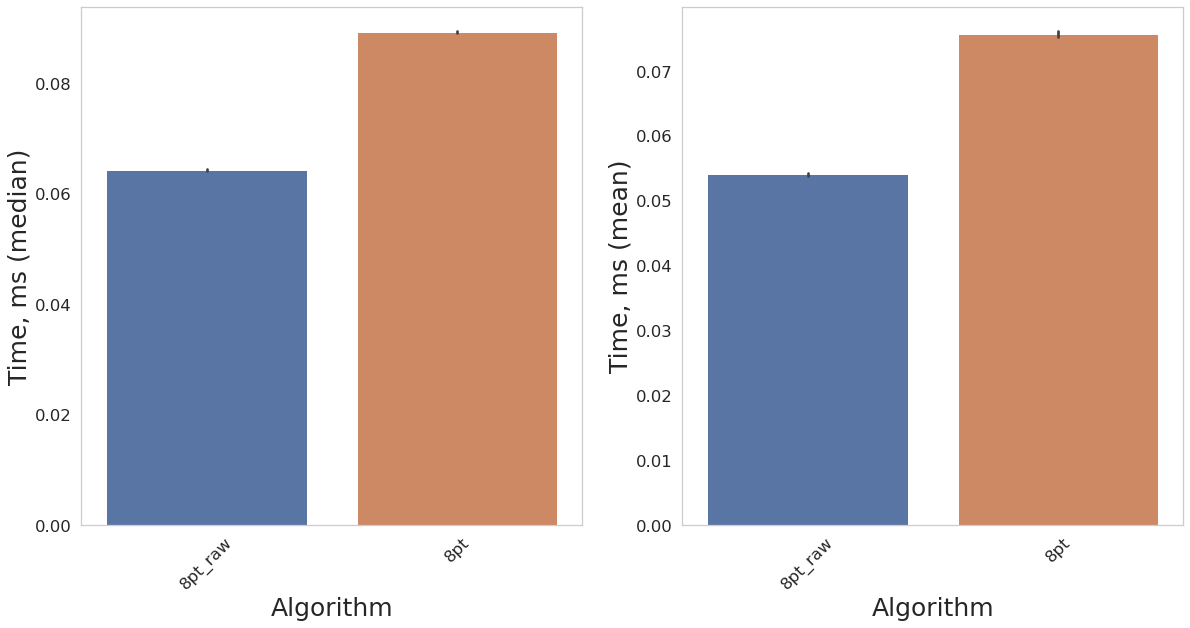

In [11]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

for i, (est_name, est) in enumerate(esimators.items()):
        order = stability_df.groupby(["method_name"])['time'].aggregate(est).reset_index().sort_values('time')
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="time", 
            data=stability_df,
            estimator=est,
            order=order['method_name']
        )
        
        axes[i].set(ylabel=f"Time, ms ({est_name})", xlabel="Algorithm")
        axes[i].yaxis.label.set_size(25)
        axes[i].xaxis.label.set_size(25)
        axes[i].tick_params(axis='x', rotation=45)